In [ ]:
!pip install keras_vggface
!pip install keras_applications

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.9 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Input, GlobalAveragePooling2D,Dropout, \
    GlobalMaxPooling2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, \
    AveragePooling2D, Reshape, Permute, multiply
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.utils.layer_utils import get_source_inputs
import warnings
from keras.models import Model
from tensorflow.keras.optimizers.legacy import SGD,Adam
from keras import layers
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

In [3]:
!gdown 1C92L4VqLNAxC1MhvlYkrC0wgXEsq2z51

Downloading...
From: https://drive.google.com/uc?id=1C92L4VqLNAxC1MhvlYkrC0wgXEsq2z51
To: /content/fer2013.zip
100% 63.3M/63.3M [00:03<00:00, 16.4MB/s]


In [4]:
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [5]:
train_dir = "./train/" # Directory containing the training data
test_dir = "./test/"  # Directory containing the validation data

In [6]:
#get train, val and test datasets
train_datagen = ImageDataGenerator(
      rescale=1./255,
      featurewise_center=False,
      featurewise_std_normalization=False,
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.5
                                  )

In [7]:
BATCH_SIZE = 128
IMG_SIZE = 197
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,           # Directory containing the training data
    target_size = (IMG_SIZE, IMG_SIZE),          # Resizes all images to 48x48 pixels
    batch_size = BATCH_SIZE,                 # Number of images per batch
    color_mode = "rgb",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    # subset = "training"  ,            # Uses the training subset of the data
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    directory = test_dir,            # Directory containing the validation data
    target_size = (IMG_SIZE, IMG_SIZE),          # Resizes all images to 48x48 pixels
    batch_size = BATCH_SIZE,                 # Number of images per batch
    color_mode = "rgb",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "validation",           # Uses the training subset of the data
    shuffle=True
    )
test_generator = validation_datagen.flow_from_directory(
    directory = test_dir,            # Directory containing the validation data
    target_size = (IMG_SIZE, IMG_SIZE),          # Resizes all images to 48x48 pixels
    batch_size = BATCH_SIZE,                 # Number of images per batch
    color_mode = "rgb",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "training",           # Uses the training subset of the data
    shuffle=True
    )

Found 28709 images belonging to 7 classes.
Found 3587 images belonging to 7 classes.
Found 3591 images belonging to 7 classes.


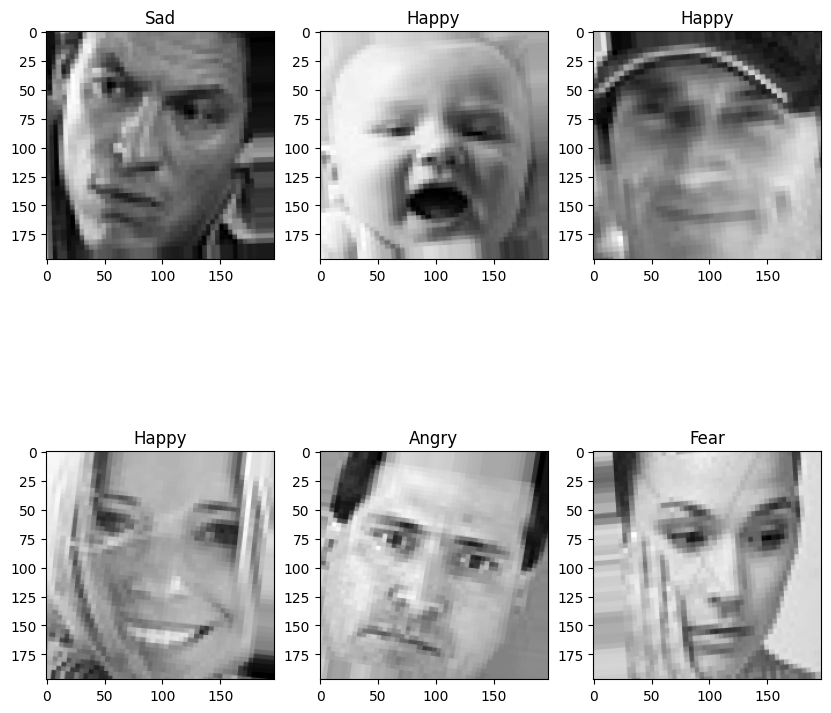

In [8]:
import random
import matplotlib.pyplot as plt
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
img , label = train_generator.__next__()
subPlot =1
plt.figure(figsize=(10,10))
for j in range(1,7):
    i = random.randint(0,(img.shape[0]-1))
    image = img[i]
    labl = class_labels[label[i].argmax()]
    plt.subplot(2,3,subPlot)
    subPlot+=1
    plt.imshow(image[:,:,0], cmap="gray")
    plt.title(labl)
plt.show()

In [ ]:
from keras import Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace

vgg_notop = VGGFace(model='vgg16', include_top=False, input_shape=(197, 197, 3), pooling='avg')
last_layer = vgg_notop.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', name='fc6')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', name='fc7')(x)
x = Dropout(0.5)(x)
    
for i in range(19):
      vgg_notop.layers[i].trainable = False

out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_notop.input, out)

model.summary()
optim = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(learning_rate=0.01, momentum=0.9, decay=0.0001, nesterov=True)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
# plot_model(model, to_file='model2.png', show_shapes=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 197, 197, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 197, 197, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 197, 197, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 98, 98, 64)        0         
                                                                 
 conv2_1 (Conv2D)            (None, 98, 98, 128)       73856     
                                                                 
 conv2_2 (Conv2D)            (None, 98, 98, 128)       147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 49, 49, 128)       0     

In [27]:
from keras.models import load_model

model = load_model('DeepLearning-Project-VGG16.h5')

In [10]:
from sklearn.utils import class_weight
import numpy as np
Y = validation_generator.classes
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes= np.unique(Y), y= Y)
class_weights_dict = {i: cw for i,cw in enumerate(class_weights)}
class_weights_dict

{0: 1.0697882493289592,
 1: 9.316883116883117,
 2: 1.0008370535714286,
 3: 0.5777097761314222,
 4: 0.8318645640074211,
 5: 0.8225177711534052,
 6: 1.2347676419965576}

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import shutil

# shutil.rmtree('./logs')
checkpoint_callback = ModelCheckpoint(
    filepath='./drive/MyDrive/DeepLearning-Project-VGG16.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1,
)
lrd = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 10,
    verbose = 1,
    factor = 0.5,
    min_lr = 0.00001)

es = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    patience=20)

tb_callback = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)

csv=tf.keras.callbacks.CSVLogger('./drive/MyDrive/DeepLearning-Project-VGG16.csv', separator=",", append=True)

history = model.fit(
    train_generator,
    steps_per_epoch=28709 // BATCH_SIZE,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=3509 // BATCH_SIZE,
    callbacks=[checkpoint_callback,lrd,tb_callback],
    class_weight= class_weights_dict
)

Epoch 1/50
224/224 [==============================] - ETA: 0s - loss: 0.8863 - accuracy: 0.6428
Epoch 1: val_accuracy improved from -inf to 0.66001, saving model to ./drive/MyDrive/DeepLearning-Project-VGG16.h5
224/224 [==============================] - 360s 2s/step - loss: 0.8863 - accuracy: 0.6428 - val_loss: 0.9199 - val_accuracy: 0.6600 - lr: 0.0100
Epoch 2/50
224/224 [==============================] - ETA: 0s - loss: 0.8837 - accuracy: 0.6415
Epoch 2: val_accuracy improved from 0.66001 to 0.66233, saving model to ./drive/MyDrive/DeepLearning-Project-VGG16.h5
224/224 [==============================] - 354s 2s/step - loss: 0.8837 - accuracy: 0.6415 - val_loss: 0.9186 - val_accuracy: 0.6623 - lr: 0.0100
Epoch 3/50
224/224 [==============================] - ETA: 0s - loss: 0.8808 - accuracy: 0.6393
Epoch 3: val_accuracy did not improve from 0.66233
224/224 [==============================] - 327s 1s/step - loss: 0.8808 - accuracy: 0.6393 - val_loss: 0.9156 - val_accuracy: 0.6594 - lr: 

In [24]:
import numpy as np
def getValues(filename, lossType):
    
    with open(filename, 'r',encoding="utf8") as file:
        content = file.read()
        words = content.split()
        l = []
        for i in range(len(words)):
            if words[i] == lossType:
                try:
                    loss_number = float(words[i+1])
                    l.append(loss_number)
                except ValueError:
                    print(f"Invalid number format after 'loss:' at position {i+1}.")
                    return None
        return l
    

train_acc = np.array(getValues('DeepLearning-Project-VGG16.txt','accuracy:'))
train_acc,counts = np.unique(train_acc, return_counts=True)
val_acc = np.array(getValues('DeepLearning-Project-VGG16.txt','val_accuracy:'))
train_loss= np.array(getValues('DeepLearning-Project-VGG16.txt','loss:'))

train_loss,counts = np.unique(train_loss, return_counts=True)
val_loss = np.array(getValues('DeepLearning-Project-VGG16.txt','val_loss:'))



{0.3477: 2, 0.4916: 2, 0.5184: 2, 0.5339: 2, 0.5436: 2, 0.5505: 2, 0.5578: 2, 0.5625: 2, 0.5638: 2, 0.5735: 2, 0.5749: 2, 0.5781: 2, 0.5842: 2, 0.5893: 2, 0.59: 2, 0.5968: 2, 0.5976: 2, 0.5978: 2, 0.6022: 2, 0.6062: 2, 0.6073: 2, 0.609: 2, 0.6096: 2, 0.6155: 2, 0.6156: 2, 0.6199: 2, 0.622: 2, 0.6226: 2, 0.6232: 2, 0.6275: 2, 0.6307: 2, 0.6393: 2, 0.6415: 2, 0.6428: 2, 0.6447: 2, 0.647: 2, 0.6474: 2, 0.6475: 2, 0.6497: 2, 0.6522: 2, 0.6556: 2, 0.657: 2, 0.6571: 2, 0.6572: 2, 0.6573: 2, 0.6598: 2, 0.662: 2, 0.6633: 2, 0.6638: 2, 0.6663: 2, 0.6673: 2, 0.6693: 2, 0.6709: 2, 0.6713: 2, 0.6715: 2, 0.6734: 2, 0.6752: 2, 0.6754: 2, 0.6766: 2, 0.6774: 2, 0.6775: 2, 0.6787: 2, 0.6793: 2, 0.6821: 2, 0.6825: 2, 0.683: 2, 0.6845: 2, 0.685: 2, 0.6851: 2, 0.6852: 2, 0.6868: 2, 0.691: 2, 0.6911: 2, 0.6922: 2, 0.6939: 2, 0.6958: 2, 0.6965: 2, 0.6966: 2, 0.6978: 2, 0.6995: 2, 0.7001: 2}
{0.731: 2, 0.7325: 2, 0.7343: 2, 0.7353: 2, 0.7358: 2, 0.7379: 2, 0.7393: 2, 0.7441: 2, 0.7558: 2, 0.7559: 2, 0.7566: 

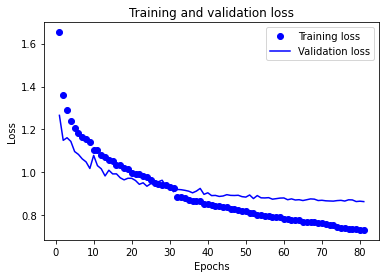

In [25]:
import matplotlib.pyplot as plt

train_loss = np.flip(train_loss)
val_loss = val_loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

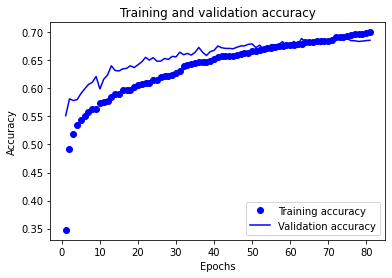

In [26]:
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
val_loss, val_acc   = model.evaluate(validation_generator)
test_loss, test_acc   = model.evaluate(test_generator)
print("test accuracy = {:.2f}".format(test_acc*100))
print("validation accuracy = {:.2f}".format(val_acc*100))